# Welcome

## Overview
During this session, you will walk through the work required to define a data science project and some recommendations for the initial approach to data. 


The goal is to perform Exploratory Data Analysis (EDA). First, you will need to help to define the project and perform data auditing. The EDA in this section will be enough for you to determine if you can accomplish the project with the information provided.
<img src='../Images/HomeScreen.png' style="width:150px;"></img>

## Pedometer App
As a new Data Scientist in the Data Science Team you have been asked to improve a pedometer app. The app's ultimate goal is to drive the user to a healthier lifestyle.

After downloading and testing the app, you notice that you need to start the recording manually, and that the only output to the user is the time and distance traveled.

Then you meet with the development team who tells you that they extract over 500 different features for you to use from the accelerometer and gyroscope information. They believe that *more data is better*.


<img src='../Images/TrackScreen.png' style="width:150px;"></img>

### Task Definition
Narrow down into actionable items the following goal: *Drive the user to a healthier lifestyle*.

Assume you have several formal and informal conversations with the stakeholders. After a lot of ideas and examples, you finally agree that you will enhance the activity tracker by providing the user with notifications and a dashboard summary showing the time spent being active and passive, resulting in suggestions to improve their lifestyle. Thus, you agree that the app will automatically record the following activities:
    - Active:
        - Walking
        - Walking upstairs
        - Walking downstairs
        - Running
        - Cycling
    - Resting
        - Sitting
        - Laying while awake
        - Laying while sleeping
        - Standing
        - Driving
        
<img src='../Images/DashboardIdea.png' style="width:150px;"></img>

### Tackling the problem
Move from a simple app that only gives the time and distance to an app that does Human Activity Recognition. Fragment this goal into small actionable items and iterate them, so you can rectify assumptions and include unexpected challenges.

You must:
- Record continuously by updating the app so it no longer requires activation.
- Verify the prediction of active and resting activities given the available information.
- Iterate the information recorded by the app and the verification to allow said predictions.
- Integrate the prediction algorithm into the app.
- Display activity trends in an engaging way.



## Data Assesment and evaluation

Good data scientists adhere to the garbage in, garbage out view of the world.

The data assessment and evaluation is a crucial stage for any Data Science project. During this stage you will verify:
- Data availability
- Data completion
- Data processing requirements
- Data usefulness

As you start to verify the prediction of resting and active activities given the available information, you have already started to do such verifications.

After another round of meetings, you gain access to a data set of an experiment the developers performed. That experiment involved 30 people (subjects), performing 6 activities (Walking, Walking upstairs, Walking downstairs, Sitting, Standing, and Lying). The features in this experiment are the result of data transformations on the gyroscope and accelerometer output.

With this data set you know that you won't be able to predict:
- Running
- Cycling
- Lying while sleeping
- Driving


In [1]:
%matplotlib inline
import collections
import os, requests, zipfile, io
import numpy as np
import pandas as pd
from itertools import islice
import plotly.graph_objs as go
import plotly.plotly as py
import pandas as pd
import matplotlib.pyplot as plt
import pprint as pp
from pandas.tools.plotting import scatter_matrix
import eda_functions
from IPython.display import Image

if not os.path.isdir('../Data/UCI HAR Dataset/'):
    HAR_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip'
    req = requests.get(HAR_URL)
    compressed = zipfile.ZipFile(io.BytesIO(req.content))
    compressed.extractall('./Data/')

## Confirm the provided information (Audit)


The data was manipulated, which may lead to several errors. These errors might be present in the form of:
- Misclassification (e.g. of the activities, the subjects, or the data)
- Incompleteness
- Incoherence (e.g. date format “YYYY-mm-DD HH:MM:SS” where “SS” (seconds) is over 60)
- Errors in using statistics (e.g. like the mean or in other transformations)

Due to:
- Dataset versioning (e.g. we’ve been provided with outdated information)
- Language and terminology discrepancies
- Undocumented manipulations
- Data format mismatch


### Explore within the files, folder structure and content
Take a look at the directories to see what is happening. Use `os.listdir(<directory>)` to see what is in the recently created “UCI HAR Dataset” directory.

Use the `pprint` or `print` functions to see the output.

In [2]:
print('UCI HAR Dataset')
print(os.listdir('../Data/UCI HAR Dataset/'))
print('TRAIN FOLDER')
print(os.listdir('../Data/UCI HAR Dataset/train'))
print('TEST FOLDER')
print(os.listdir('../Data/UCI HAR Dataset/test'))

UCI HAR Dataset
['.DS_Store', 'activity_labels.txt', 'features.txt', 'features_info.txt', 'README.txt', 'test', 'train']
TRAIN FOLDER
['Inertial Signals', 'subject_train.txt', 'X_train.txt', 'y_train.txt']
TEST FOLDER
['Inertial Signals', 'subject_test.txt', 'X_test.txt', 'y_test.txt']


### Train and test folders

Currently, you have:
- 4 different text files in the beginning, which seem to be data dictionaries/labels for the internal datasets.
- 2 folders with similar content: Test and Train.
    - Inside the folders, you see two .txt files: X and Y. X is used to describe the independent variables and Y is the dependent variable, which is the objective function; in other words, the activity categorization for each combination of X’s variables.
    
Why would **Test** and **Train** have the same structure?


## Confirm the provided information (Audit part 2)

Remember that the data was manipulated which might lead to several errors. Look at the number of subjects, features, and activities to confirm they are what you’ve been told, and see where the difference come from otherwise. 

### Load the data

After exploring the file and folder structure, load the data for its consumption.


In [3]:
#load activities and set them to their meanings
activity_label = {int(key): value for key, value in eda_functions.get_key_value_pairs('../Data/UCI HAR Dataset/activity_labels.txt')}
activities = pd.read_table('../Data/UCI HAR Dataset/train/y_train.txt', header=None, delim_whitespace=True)
activities.columns = ['activity']
activities = activities.replace({'activity':activity_label})

#load subjects
subjects = [int(line.strip()) for line in open('../Data/UCI HAR Dataset/train/subject_train.txt','r')]

#load the feature names
features = np.array([line.strip().split(' ')[1] for line in open('../Data/UCI HAR Dataset/features.txt', 'r')])

#load the observations
observations= pd.read_table('../Data/UCI HAR Dataset/train/X_train.txt', header=None, delim_whitespace=True, names=features)
observations['subject'] = subjects
observations['activities'] = activities

### Brief look at the data
Now execute simple commands to get the counts and a very summarized view of the data.

#### Activity

In [4]:
collections.Counter(activities.activity)

Counter({'LAYING': 1407,
         'SITTING': 1286,
         'STANDING': 1374,
         'WALKING': 1226,
         'WALKING_DOWNSTAIRS': 986,
         'WALKING_UPSTAIRS': 1073})

#### Subjects

In [5]:
collections.Counter(subjects)

Counter({1: 347,
         3: 341,
         5: 302,
         6: 325,
         7: 308,
         8: 281,
         11: 316,
         14: 323,
         15: 328,
         16: 366,
         17: 368,
         19: 360,
         21: 408,
         22: 321,
         23: 372,
         25: 409,
         26: 392,
         27: 376,
         28: 382,
         29: 344,
         30: 383})

#### predictors/features


In [6]:
print(features.size)
print(features[1:5])

561
['tBodyAcc-mean()-Y' 'tBodyAcc-mean()-Z' 'tBodyAcc-std()-X'
 'tBodyAcc-std()-Y']


#### observations

In [7]:
print(observations.head())

   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944         -0.996520         -0.963668   
3         -0.983403         -0.990675         -0.997099         -0.982750   
4         -0.980817         -0.990482         -0.998321         -0.979672   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X     ...      \
0  

#### size and matching

In [8]:
print(observations.shape)
print(features.size)
print(len(subjects))
print(activities.shape)

(7352, 563)
561
7352
(7352, 1)


# Statistics review
For this section, **only** look at the **Train** data, as this is the set for the modeling.

**Note:** Remember that the test data is for model validation.



## Tendency measures
To gather data about percentiles and central tendency use `observations.shape`.



In [9]:
print(observations.shape)

(7352, 563)


This dataset has all the features (561 in the features file), and all the observations (7352 corresponding to the number of rows in the activity dataset).

Use `observations.describe()` to obtain the basic measurements.

In [10]:
observations.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515,17.413085
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122,8.975143
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414,8.000000
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181,19.000000
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659,26.000000
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000,30.000000


You can confirm two important things:
- You are aggregating already aggregated columns (e.g. you are looking at means of means).
- You have too much data and there does not seem to be something evidently useful.

By comparing for example at the `tBodyAcc-mean()-Z` and `tBodyAcc-max()-Z` you can see that there is a measure of more variation and a wider range.


## Barplots and Histograms

Since **activities** is what you are trying to predict and understand, see how much representation for each of them is in the dataset, as it may affect the model if there is too much bias.

### Barplots
Create a barplot with the count of occurrences for each activity. The easiest way to solve this is by calling the activity column with `activities.activity`, applying `.value_counts()` and plotting with `.plot(kind='bar')`.


LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: activity, dtype: int64


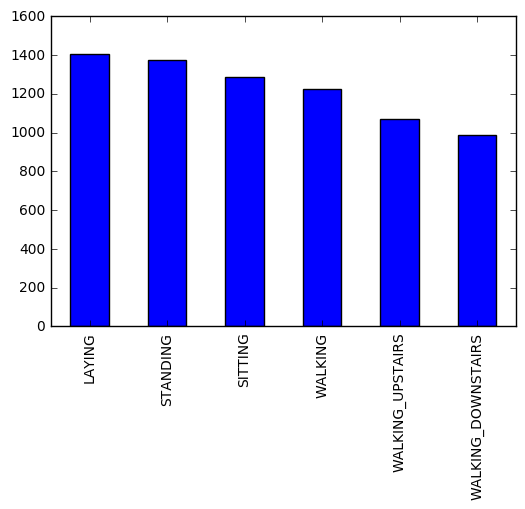

In [11]:
print(activities.activity.value_counts())
activities.activity.value_counts().plot(kind='bar')

Now, make the same for the `subjects` data (which is a list).

Keep in mind that `value_counts` only works with Pandas series. Use `pd.Series(subjects)` to convert it into that.

25    409
21    408
26    392
30    383
28    382
27    376
23    372
17    368
16    366
19    360
1     347
29    344
3     341
15    328
6     325
14    323
22    321
11    316
7     308
5     302
8     281
dtype: int64


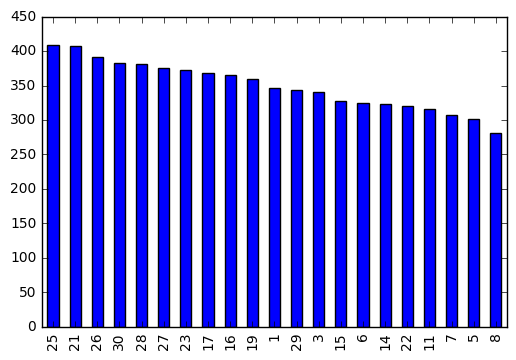

In [12]:
print(pd.Series(subjects).value_counts())
pd.Series(subjects).value_counts().plot(kind='bar')

### Histogram
Reduce the dataset to the total body acceleration columns, since they are the ones having differences in their distribution.


In [13]:
estimated = 'tBodyAcc'
meanfeatures = np.array([feature for feature in features if estimated in feature ])
meanfeatures = np.append(meanfeatures,['activities','subject'])
observed_feature = observations[meanfeatures]
subsetuser = observed_feature[observed_feature['subject']==1]

Now you have plotted a histogram with the mean total body acceleration on the **Z** axis for all our subjects. Remember, it is expected for it it to have a variation.


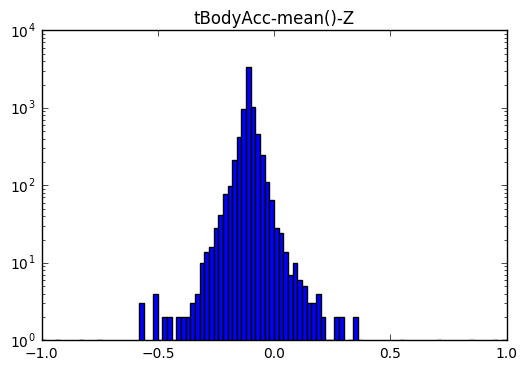

In [14]:
feature = 'tBodyAcc-mean()-Z'
mean_series_to_plot = observed_feature[feature]
eda_functions.hist_plot(mean_series_to_plot, feature, 100, True)

Now replicate the code for the maximum total body acceleration `tBodyAcc-max()-Z`.

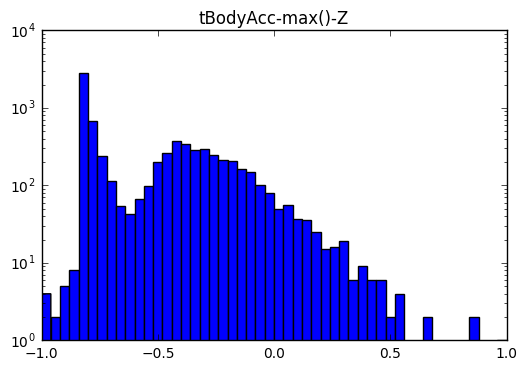

In [15]:
feature = 'tBodyAcc-max()-Z'
max_series_to_plot = observed_feature[feature]

eda_functions.hist_plot(max_series_to_plot, feature, 50, True)

Now, take a look at only one subject so that you can understand with one example what is going on. For this, use the `subsetuser` dataframe, which containes only the first subject (i.e. `observed_feature[observed_feature['subject']==1]`), and replicate the previous code; first with the mean then with the max values.

**Note:** to change the subject go to the code cell right below the histogram subtitle and change the number id in the corresponding line.

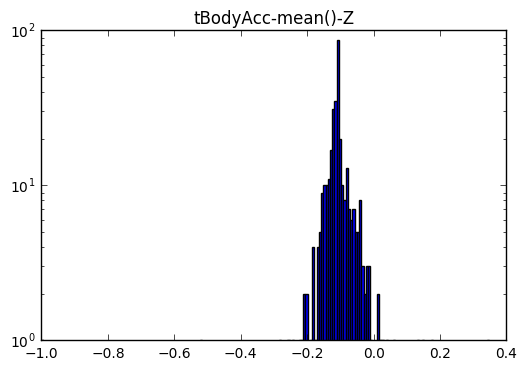

In [16]:
feature = 'tBodyAcc-mean()-Z'
user_mean_series_to_plot = subsetuser[feature]

eda_functions.hist_plot(user_mean_series_to_plot, feature, 200, True)

With this, you can see that the mean differs, so there is variability between people.

You could argue that this may be because someone spent a longer time doing one activity rather than another. To test this, let’s use the `tBodyAcc-max()-Z` and look at when the subject is walking.

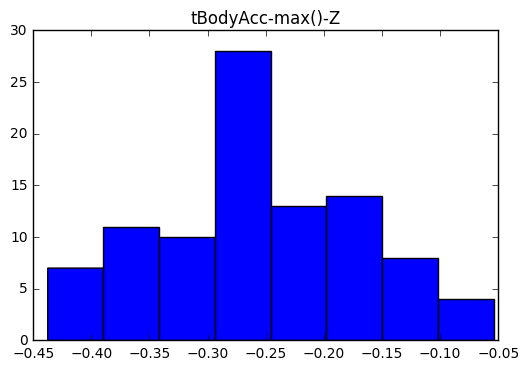

In [17]:
feature = 'tBodyAcc-max()-Z'
walking_user_max_series_to_plot = subsetuser.loc[subsetuser['activities']=='WALKING',feature]
plt.hist(walking_user_max_series_to_plot, bins='auto')
plt.title(feature)


Now see what happens when he is sitting.

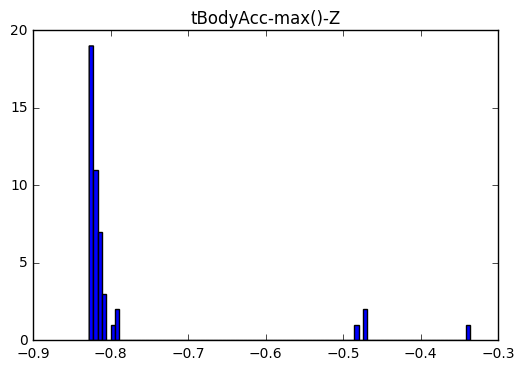

In [18]:
plt.figure()
feature = 'tBodyAcc-max()-Z'
sitting_user_max_series_to_plot = subsetuser.loc[subsetuser['activities']=='SITTING',feature]

plt.hist(sitting_user_max_series_to_plot, bins='auto')
plt.title(feature)


You now know that there is variability.
- **Activity variability:** There seem to be some features that will give information to identify each activity.
- **User variability:** This seems to introduce some noise. Since, as a Data Scientist, you should go from simple to more elaborate solutions, you will now only look at one user for our analysis until you are satisfied this has been enough.



If you start talking about its implementation, you may be implying that you want to create one model per user instead of generalizing how any human being may perform each activity (In this scenario, the arrival of a new user, for whom there is no information to build their model). This is formally known as the **cold start** problem.


For now, don’t worry about that problem. You are still understanding the data and its behaviors and you are not sure we can generate something out of it. Keep it simple.

### Quantiles and boxplots

Look from a different view the same data and you might get a better idea of what is the main identifier.

Boxplots are another way to visualize a variable’s distribution, making really evident the interquartile range, the presence of outliers, and the median.

The mean total body acceleration for the **Z** axis is already plotted for you to see.


{'boxes': [<matplotlib.lines.Line2D at 0x111acd6d8>],
 'caps': [<matplotlib.lines.Line2D at 0x111ad0fd0>,
 'fliers': [],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x111ad3a90>],
 'whiskers': [<matplotlib.lines.Line2D at 0x111acdf60>,
  <matplotlib.lines.Line2D at 0x111ad0898>]}

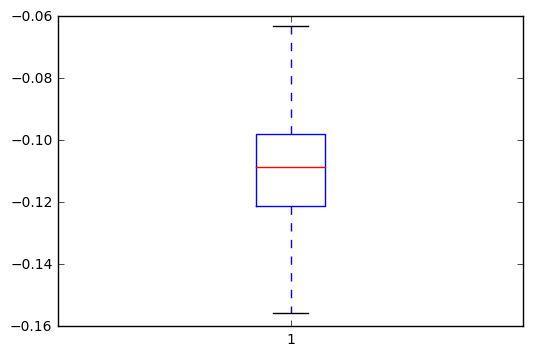

In [19]:
plt.boxplot(observed_feature['tBodyAcc-mean()-Z'], showfliers=False)



Replicate the code for the maximum values on axis **Z** (`tBodyAcc-max()-Z`).


{'boxes': [<matplotlib.lines.Line2D at 0x111d684a8>],
 'caps': [<matplotlib.lines.Line2D at 0x111d71eb8>,
 'fliers': [],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x111d76860>],
 'whiskers': [<matplotlib.lines.Line2D at 0x111d68e48>,
  <matplotlib.lines.Line2D at 0x111d68fd0>]}

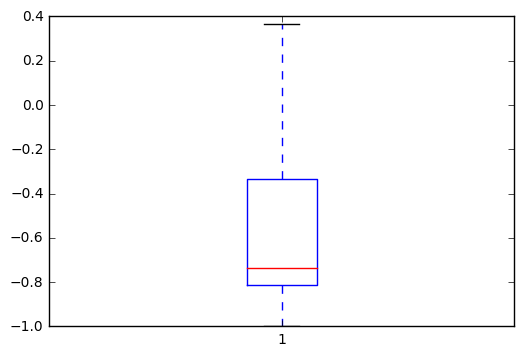

In [20]:
plt.boxplot(observed_feature['tBodyAcc-max()-Z'], showfliers=False)


### Scatterplot

So far, you have looked at one-dimensional analysis, and this has already shed interesting insights into the data. Nevertheless, you have plenty of data and you want to see their interactions. A scatterplot is a bidimensional tool and is useful for understanding correlations and data capacity, among other things.

Since you have a lot of data, instead of plotting one combination of values, you can use the `scatter_matrix` function from the `Pandas` plotting tools. This is useful because it gives you the density plot in the diagonal. All you need to know about it is that it is some sort of histogram smoothing.

**Note:** In reality it to obtain this diagonal the code performs a *kernel density estimation*, which starts making inferences about the data which we do not want to formalize during the exploratory data analysis, so it will not be delved into.


The `scatter_matrix_plot()` simplifies the plotting of all 3 axes of any variable. Use it to look at the the static activities' scatter plot.


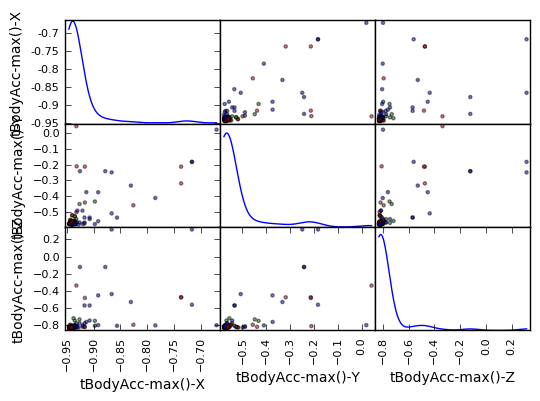

In [21]:
eda_functions.scattermatrixplot(subsetuser,'activities',['SITTING','STANDING','LAYING'],'tBodyAcc-max()')

There is no evident correlation in the total body acceleration for the *static activities* since the person is not moving. You may explain the outliers or most of the changes with the breathing movement or other sources of *noise*.

Now plot the dynamic activities 'WALKING', 'WALKING_UPSTAIRS' and 'WALKING_DOWNSTAIRS' to compare and contrast.

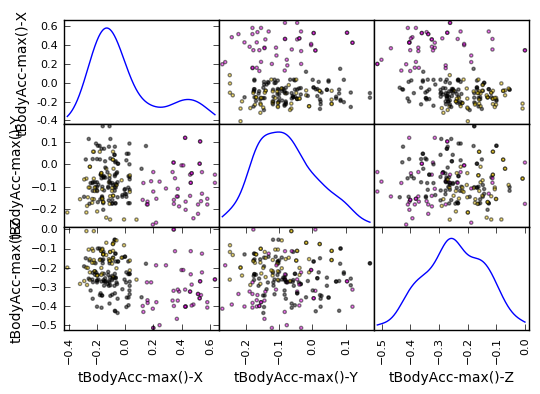

In [22]:
eda_functions.scattermatrixplot(subsetuser,'activities',['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS'],'tBodyAcc-max()')

You may play more with the data and scatterplot you desire to generate here.

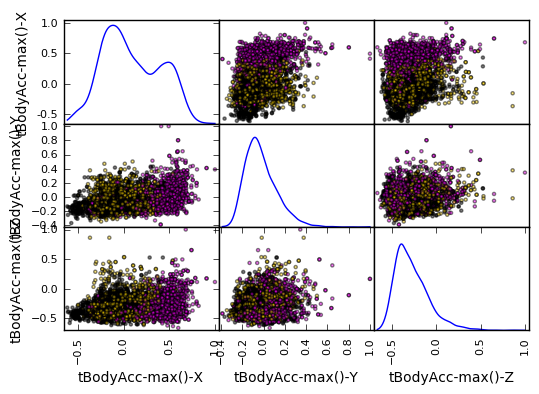

In [23]:
eda_functions.scattermatrixplot(observed_feature,'activities',['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS'],'tBodyAcc-max()')

## Summary
What the developers described is data that might be useful in creating a dashboard. You found that some features in the data might help classify both active and resting activities.
